In [52]:
pip install opendatasets

In [53]:
import opendatasets as od
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn

In [54]:
url = "https://www.kaggle.com/datasets/splcher/animefacedataset"
od.download(url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [55]:
DATA = './animefacedataset'
print (os.listdir(DATA))

['images']


In [56]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5) , (0.5,0.5,0.5)


In [57]:
train_ds = ImageFolder(DATA , transform=T.Compose
                      ([
                          T.Resize(image_size),
                          T.CenterCrop(image_size),
                          T.ToTensor(),
                          T.Normalize(*stats)
                      ]))
train_dl = DataLoader(train_ds ,
                      batch_size,
                      shuffle=True
                      ,num_workers=3 
                      , pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [58]:
def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]

In [59]:
def show_img (images , nmax=64):
    fig , ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([]) ; ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]) , nrow = 8).permute(1,2,0))
    

In [60]:
def show_batch(dl , nmax = 64) : 
    for images , _ in dl :
        show_img(images,nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


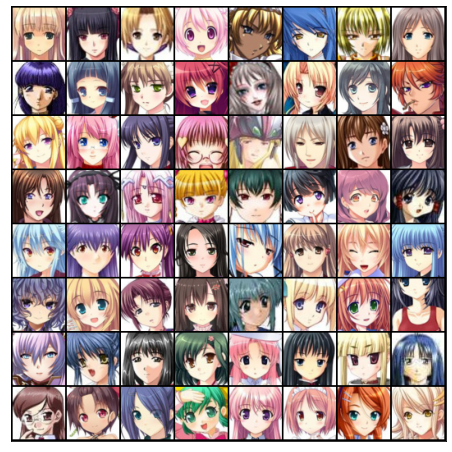

In [61]:
show_batch(train_dl)

In [62]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [63]:
dev = get_default_device()

In [64]:
train_dl = DeviceDataLoader (train_dl , dev)

##Discriminator Network

In [65]:
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.batchnorm import BatchNorm2d
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [66]:
discriminator = to_device(discriminator , dev)

##Generator Network

vec or a matrix of random numbers which is used as a seed for generating an image (Latent) . it convert Latent tensor of shape `(128 , 1 , 1)` into an image tensor `3 x 28 x 28` by using `ConvTranspose2d`which is Reverse convolution

In [67]:
latent_size = 128

In [68]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


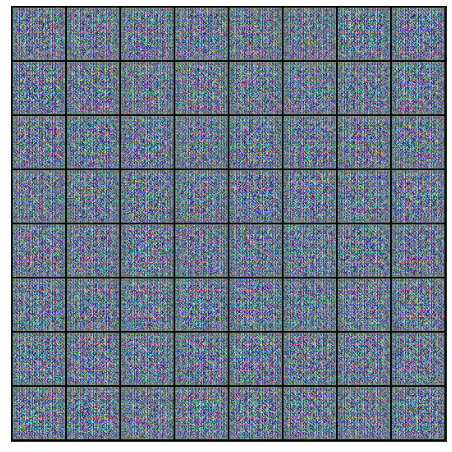

In [69]:
xb = torch.randn (batch_size , latent_size , 1 , 1)
fake_images = generator(xb)
print(fake_images.shape)
show_img(fake_images)

In [70]:
generator = to_device(generator , dev)

## Discriminator Training 

train the Discriminator then train the genetaror

In [71]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=dev)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=dev)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=dev)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator trainning

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

* We generate a batch of images using the generator, pass the into the discriminator.

* We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

* We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images.

In [86]:
 def train_generator(opt_g):
    #Clear generator Grads
    opt_g.zero_grad()

    # Generate fake images 
    latnet = torch.randn(batch_size, latent_size , 1 , 1 , device=dev)
    fake_images = generator(latnet)

    #try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size , 1 ,device=dev)
    loss = F.binary_cross_entropy (preds , targets)



    # Backprop and optimize
    
    loss.backward()
    opt_g.step()

    
    return loss.item()

## Training the Model
Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model

In [73]:
from torchvision.utils import save_image

In [74]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [75]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [76]:
fixed_latent = torch.randn (64 , latent_size , 1 , 1 , device =dev)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


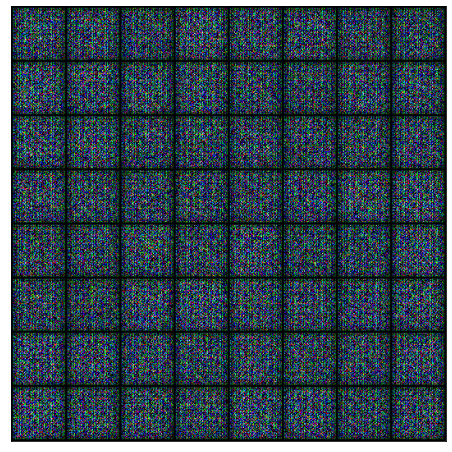

In [77]:
save_samples (0 , fixed_latent)

## Trainnig Loop

Let's define a fit function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

In [78]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [83]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [89]:
lr = 0.0002
epochs = 15

In [90]:
history = fit(epochs,lr )

  0%|          | 0/497 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/15], loss_g: 6.4526, loss_d: 0.4193, real_score: 0.9006, fake_score: 0.2400
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/15], loss_g: 5.1024, loss_d: 0.5785, real_score: 0.6615, fake_score: 0.0047
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/15], loss_g: 9.6171, loss_d: 0.3135, real_score: 0.9979, fake_score: 0.2203
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/15], loss_g: 9.0297, loss_d: 0.3367, real_score: 0.9438, fake_score: 0.2168
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/15], loss_g: 5.8901, loss_d: 0.3286, real_score: 0.7679, fake_score: 0.0110
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/15], loss_g: 6.3179, loss_d: 0.5266, real_score: 0.6702, fake_score: 0.0013
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/15], loss_g: 6.0470, loss_d: 0.1286, real_score: 0.9415, fake_score: 0.0561
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/15], loss_g: 3.3477, loss_d: 0.3471, real_score: 0.8275, fake_score: 0.0991
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/15], loss_g: 6.7895, loss_d: 0.0238, real_score: 0.9817, fake_score: 0.0027
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/15], loss_g: 5.5947, loss_d: 0.1576, real_score: 0.9648, fake_score: 0.1058
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/15], loss_g: 4.8379, loss_d: 0.2042, real_score: 0.9227, fake_score: 0.0949
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/15], loss_g: 4.5446, loss_d: 0.1300, real_score: 0.9302, fake_score: 0.0461
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/15], loss_g: 3.2512, loss_d: 0.2167, real_score: 0.8540, fake_score: 0.0164
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/15], loss_g: 5.0073, loss_d: 0.1202, real_score: 0.9733, fake_score: 0.0804
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/15], loss_g: 3.7743, loss_d: 0.1828, real_score: 0.8591, fake_score: 0.0112
Saving generated-images-0015.png


In [91]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()